<a href="https://colab.research.google.com/github/akhandait/advanced-machine-learning-with-neural-networks-homeworks/blob/main/homeworks/hw1_problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 1 | Problem 1

In [51]:
!pip install deeplay  # Uncomment if using Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Loading the MNIST Dataset

In [2]:
import os
from torchvision.datasets.utils import _extract_zip, download_url

dataset_path = os.path.join(".", "mnist_dataset")
if not os.path.exists(dataset_path):
    url = "https://github.com/DeepTrackAI/MNIST_dataset/raw/main/mnist.zip"
    download_url(url, ".")
    _extract_zip("mnist.zip", dataset_path, None)
    os.remove("mnist.zip")

100%|██████████| 30.2M/30.2M [00:00<00:00, 195MB/s]


In [24]:
def get_label_from_filename(path):
    """Extract the label (first character before underscore) from the file name."""
    filename = os.path.basename(path)  # e.g. "8_002434.png"
    label_str = filename.split('_')[0]  # "8"
    return float(label_str)

In [25]:
class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)
        label = get_label_from_filename(path)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return image, label

### Transforming the Images and Their Ground Thruth

Define a transformation to convert the images to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1) ...

In [1]:
from torchvision.transforms import Compose, Resize, ToTensor

image_trans = Compose([ToTensor()])

In [63]:
import torch

def label_trans(label):
    """Transform label."""
    return torch.tensor(label).long()

... and define a dataset that also makes these transformations.

In [64]:
from torchvision.datasets import ImageFolder

base_dir = os.path.join(dataset_path, "mnist")
dataset = CustomImageFolder(base_dir, transform=image_trans,
                            target_transform=label_trans)

### Visualizing MNIST

Implement a function to plot some examples of the data ...

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_mnist(dataset):
    """Plot mnist."""
    fig, axs = plt.subplots(3, 6, figsize=(16, 8))
    for ax in axs.ravel():
        image, label = dataset[np.random.randint(0, len(dataset))]
        if isinstance(image, torch.Tensor):
            image, label = image.numpy().transpose(1, 2, 0), label.numpy()
        ax.imshow(image)
        ax.set_title(f"{label}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [66]:
dataset

Dataset CustomImageFolder
    Number of datapoints: 70000
    Root location: ./mnist_dataset/mnist
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Target transform: <function label_trans at 0x79616c1cd1c0>

... and use it to plot them.

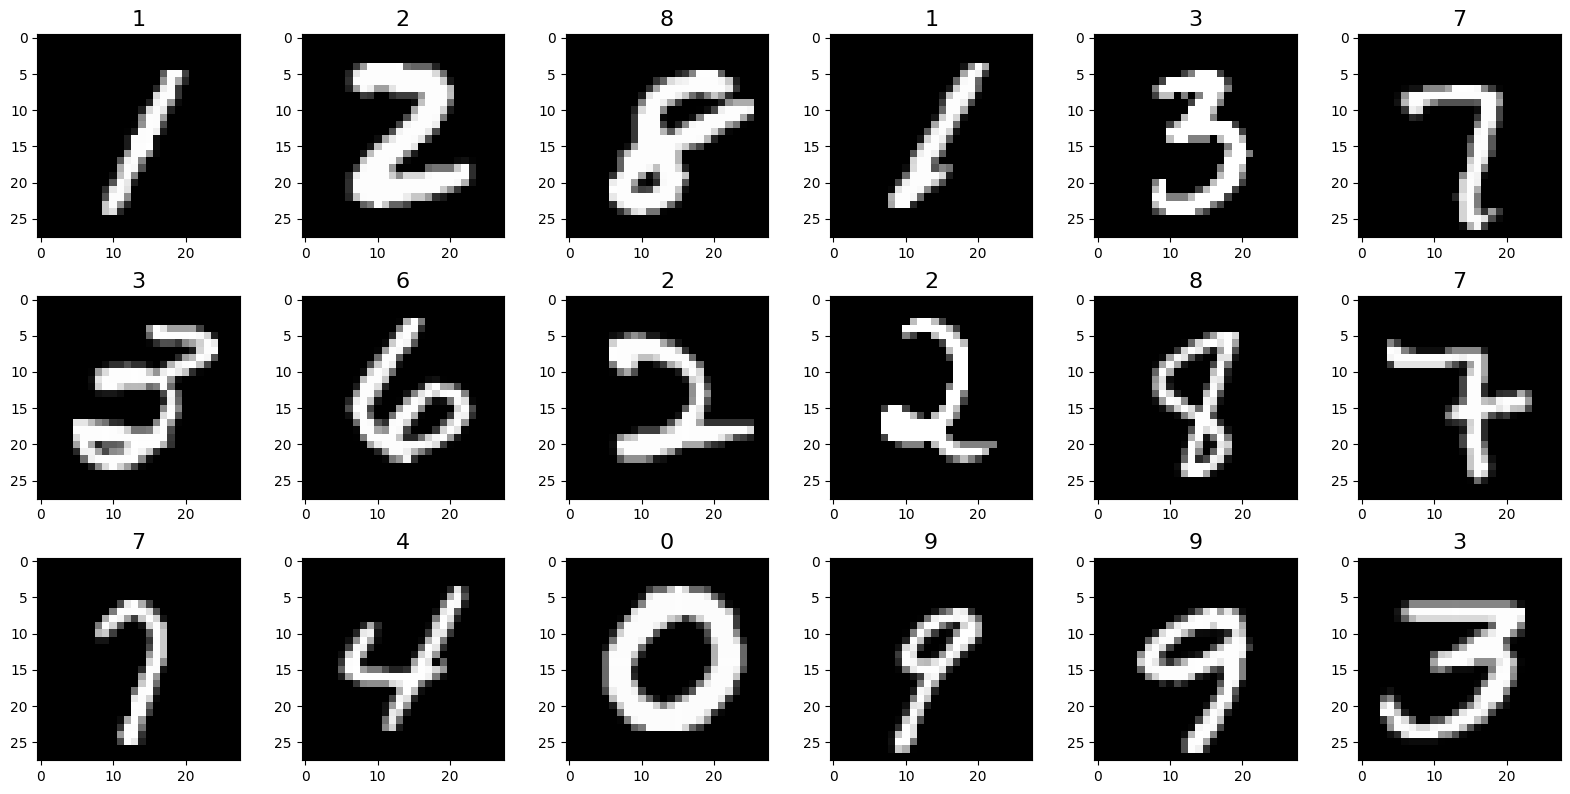

In [67]:
plot_mnist(dataset)

### Splitting the Dataset and Defining the Data Loaders


In [68]:
test_indices = list(range(10000))
train_indices = list(range(10000, 70000))

In [69]:
from torch.utils.data import Subset

test = Subset(dataset, test_indices)
train = Subset(dataset, train_indices)

... and define the data loaders.

In [81]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=256, shuffle=True)

## Classifying MNIST with Dense Neural Networks

Implement a dense neural network ...

In [82]:
import deeplay as dl

dnn = dl.MultiLayerPerceptron(
    in_features=28 * 28 *3, hidden_features=[16, 16], out_features=10,
    out_activation=torch.nn.Softmax,
)

... print out its detailed architecture ...

In [83]:
print(dnn)

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Layer[Linear](in_features=2352, out_features=16, bias=True)
      (activation): Layer[ReLU]()
    )
    (1): LinearBlock(
      (layer): Layer[Linear](in_features=16, out_features=16, bias=True)
      (activation): Layer[ReLU]()
    )
    (2): LinearBlock(
      (layer): Layer[Linear](in_features=16, out_features=10, bias=True)
      (activation): Layer[Softmax]()
    )
  )
)


... compile it ...

In [84]:
from torch.nn import CrossEntropyLoss

classifier_template = dl.Classifier(
    model=dnn, num_classes=10, make_targets_one_hot=True,
    loss=CrossEntropyLoss(), optimizer=dl.RMSprop(lr=0.001),
)
dnn_classifier = classifier_template.create()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


... and print out the compiled dense neural network.

In [85]:
print(dnn_classifier)

Classifier(
  (loss): CrossEntropyLoss()
  (optimizer): RMSprop[RMSprop](lr=0.001)
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Linear(in_features=2352, out_features=16, bias=True)
        (activation): ReLU()
      )
      (1): LinearBlock(
        (layer): Linear(in_features=16, out_features=16, bias=True)
        (activation): ReLU()
      )
      (2): LinearBlock(
        (layer): Linear(in_features=16, out_features=10, bias=True)
        (activation): Softmax(dim=None)
      )
    )
  )
)


### Training the Dense Neural Network

In [86]:
dnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
dnn_trainer.fit(dnn_classifier, train_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                 | Params | Mode 
---------------------------------------------------------------
0 | loss          | CrossEntropyLoss     | 0      | train
1 | train_metrics | MetricCollection     | 0      | train
2 | val_metrics   | MetricCollection     | 0      | train
3 | test_metrics  | MetricCollection     | 0      | train
4 | model         | MultiLayerPerceptron | 38.1 K | train
5 | optimizer     | RMSprop              | 0      | train
---------------------------------------------------------------
38.1 K    Trainable params
0         Non-trainable params
38.1 K    Total params
0.152     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                

Training: |          | 0/? [00:00<?, ?it/s]

### Testing the Dense Neural Network

In [87]:
dnn_trainer.test(dnn_classifier, test_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.8533999919891357      │
│       test_loss_epoch        │      1.6080158948898315      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 1.6080158948898315,
  'testMulticlassAccuracy_epoch': 0.8533999919891357}]

### Plotting the ROC Curve

Implement a function to plot the ROC curve ...

In [88]:
import torchmetrics as tm

def plot_roc(classifier, loader):
    """Plot ROC curve."""
    roc = tm.ROC(task="multiclass", num_classes=10)
    for image, label in loader:
        roc.update(classifier(image), label.long())

    fig, ax = roc.plot(score=True)
    ax.grid(False)
    ax.axis("square")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc="center right")
    plt.show()

... and use it to plot the performance of the classifier based on a dense neural network.

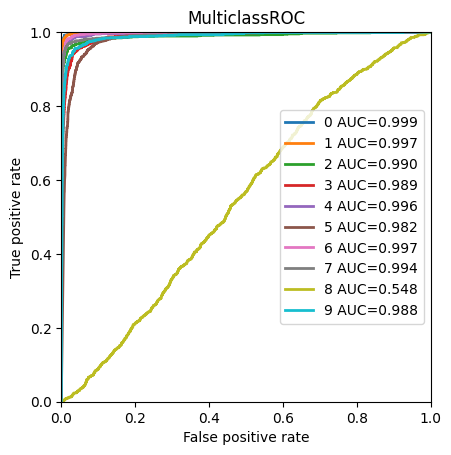

In [89]:
plot_roc(dnn_classifier, test_loader)

## Classifying MNIST with Convolutional Neural Networks

Implement a convolutional neural network with a dense top ...

In [96]:
conv_base = dl.ConvolutionalNeuralNetwork(
    in_channels=3, hidden_channels=[16, 16, 32], out_channels=32,
)
conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(
    in_features=32, hidden_features=[], out_features=10,
    out_activation=torch.nn.Softmax,
)

cnn = dl.Sequential(conv_base, connector, dense_top)

... print out its detailed architecture ...

In [97]:
print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (3): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[Identity]()
      )
    )
  )
  (1): Layer[AdaptiveAvgPool2d](output_size=1)
  (2): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=10, bias=T

... compile it ...

In [98]:
classifier_template = dl.Classifier(
    model=cnn, num_classes=10, make_targets_one_hot=True,
    loss=CrossEntropyLoss(), optimizer=dl.RMSprop(lr=0.001),
)
cnn_classifier = classifier_template.create()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


... and print out the compiled convolutional neural network.

In [99]:
print(cnn_classifier)

Classifier(
  (loss): CrossEntropyLoss()
  (optimizer): RMSprop[RMSprop](lr=0.001)
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (

### Training the Convolutional Neural Network

In [100]:
cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
cnn_trainer.fit(cnn_classifier, train_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 17.0 K | train
5 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)
30        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

### Testing the Convolutional Neural Network

In [101]:
cnn_trainer.test(cnn_classifier, test_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.9598000049591064      │
│       test_loss_epoch        │      1.5020413398742676      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 1.5020413398742676,
  'testMulticlassAccuracy_epoch': 0.9598000049591064}]

### Plotting the ROC Curve

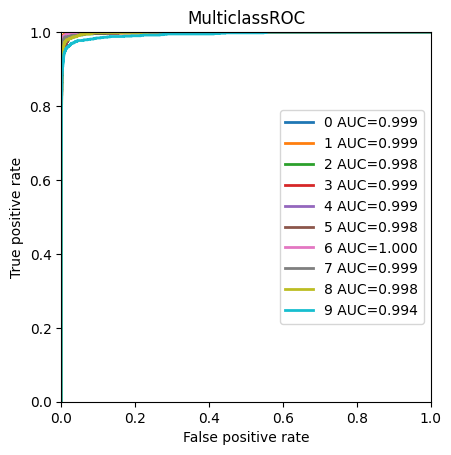

In [102]:
plot_roc(cnn_classifier, test_loader)